
References:

[1] Hector Morrell and Hiu Yung Wong, "Step-by-Step HHL Algorithm Walkthrough to Enhance the Understanding of Critical Quantum Computing Concepts", arXiv preprint arXiv:2108.09004


In [1]:
# Imports for Qiskit
from qiskit.compiler import transpile
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.circuit.library.standard_gates import RYGate
from qiskit.visualization import plot_histogram
from qiskit.circuit.library import QFT
# various imports
import numpy as np
from matplotlib import pyplot as plt

def qpe(circ, clock, input, c_qubits):
    circ.barrier()

    for j in range(c_qubits):
        for _ in range(2**j):
            circ.cu(np.pi/2, -np.pi/2, np.pi/2, 3*np.pi/4, clock[j], input)

    circ.barrier()
    
    # Perform an inverse QFT on the register holding the eigenvalues
    circ.compose(
    QFT(c_qubits, inverse=True), clock,
    inplace=True)
    
def inv_qpe(circ, clock, input, c_qubits):
    
    # Perform a QFT on the register holding the eigenvalues
    circ.compose(
    QFT(c_qubits, inverse=False), clock,
    inplace=True)

    circ.barrier()

    for j in range(c_qubits):
        for _ in range(2**j):
            circ.cu(np.pi/2, np.pi/2, -np.pi/2, -3*np.pi/4, clock[j], input)

    circ.barrier()

def hhl(circ, ancilla, clock, input, c_qubits):
    
    qpe(circ, clock, input, c_qubits)

    circ.barrier()
    
    circ.cry(2*np.asin(1), clock[c_qubits-2], ancilla)
    circ.cry(2*np.asin(1/2), clock[c_qubits-1], ancilla)

    #deferred measurement principle
    #circuit.measure(ancilla, measurement[0])
    circ.barrier()
    inv_qpe(circ, clock, input, c_qubits)

def hhl_complete(circ, ancilla, clock, input, measurement, c_qubits): # State preparation. 
    intial_state = [0,1]
    circ.initialize(intial_state, c_qubits+1)

    circ.barrier()

    # Perform a Hadamard Transform
    circ.h(clock)

    hhl(circ, ancilla, clock, input, c_qubits)

    # Perform a Hadamard Transform
    circ.h(clock)

    circ.barrier()

    circ.measure(ancilla, measurement[0])
    circ.measure(input, measurement[1])
    return circ

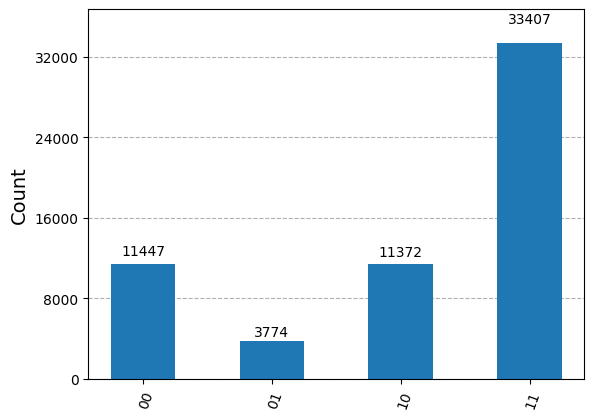

In [2]:
from qiskit_aer import AerSimulator

c_qubits = 2
# Create the various registers needed
clock = QuantumRegister(c_qubits, name='clock')
input = QuantumRegister(1, name='b')
ancilla = QuantumRegister(1, name='ancilla')
measurement = ClassicalRegister(2, name='c')

# Create an empty circuit with the specified registers
circuit = QuantumCircuit(ancilla, clock, input, measurement)
circuit.barrier()
hhl_complete(circuit, ancilla, clock, input, measurement, c_qubits)

simulator = AerSimulator()
circuit_compiled = transpile(circuit, simulator)
job_sim = simulator.run(circuit_compiled, shots=60000)
#Get the result of the execution
result_sim = job_sim.result()

# Get the counts, the frequency of each answer
counts = result_sim.get_counts(circuit_compiled)


plot_histogram(counts)

In [3]:

x1_count = counts['01'] #ancilla is 1, b is 0
x2_count = counts['11'] #ancilla is 1, b is 1
ratio = x2_count/x1_count
print(x2_count/x1_count)

8.851881293057764


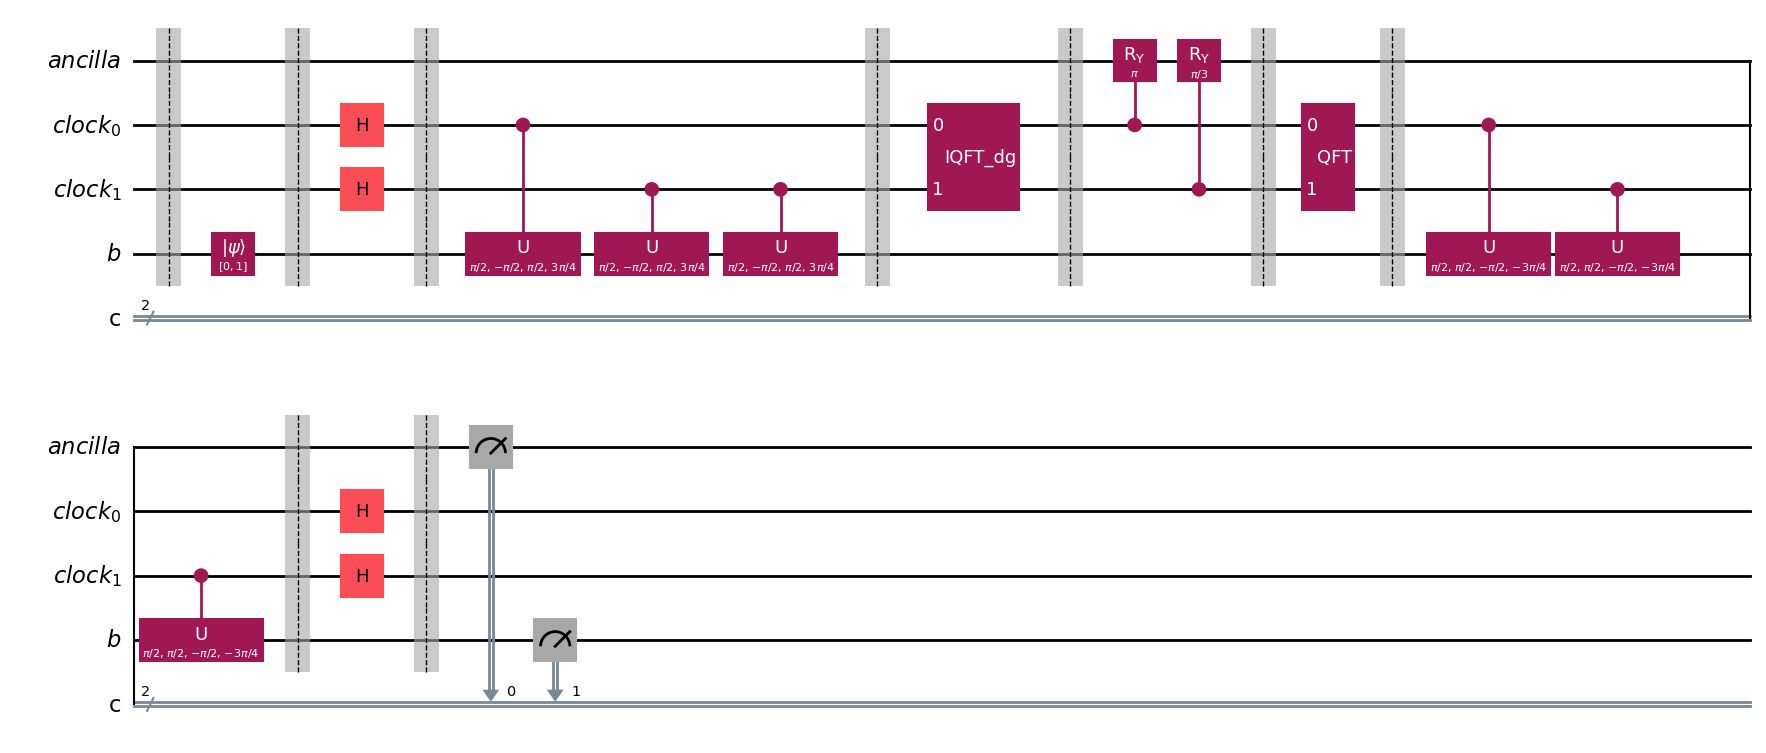

In [4]:
circuit.draw('mpl')